# Imports and setup

In [ ]:
# Librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
import rasterio
from rasterio import plot
from rasterio.plot import show
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
import matplotlib
from matplotlib.colors import ListedColormap
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split

In [41]:
torch.random.manual_seed(0)
!nvidia-smi

Thu May 15 20:15:56 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.80                 Driver Version: 546.80       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8              11W / 120W |   8025MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [42]:
# Definición de la arquitectura U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.conv_last = nn.Conv2d(64, out_channels, 1)
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        return torch.sigmoid(self.conv_last(dec1))

In [43]:
# Dataset personalizado para imágenes TIFF (4 bandas) y máscaras PNG binarias
class FourBandSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, files_list=None):
        if files_list is not None:
            self.image_files = files_list[0]
            self.mask_files = files_list[1]
        else:
            self.image_files = sorted(glob.glob(images_dir + "/*.tif"))
            self.mask_files = sorted(glob.glob(masks_dir + "/*.png"))
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        # Imagen 4 bandas
        with rasterio.open(self.image_files[idx]) as src:
            img = src.read()  # (bands, H, W)
            img = np.transpose(img, (1, 2, 0)).astype(np.float32)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            img = np.transpose(img, (2, 0, 1))  # (4, H, W)
        # Máscara binaria
        mask = Image.open(self.mask_files[idx]).convert('L')
        mask = np.array(mask)
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)  # (1, H, W)
        return torch.from_numpy(img), torch.from_numpy(mask)

In [61]:
# Rutas y split de datos
images_dir = r"C:\\Users\\Leonardo\\Documents\\Tesis\\Tesis2\\Imagenes\\AI4boundariesDS\\Input4bands"
masks_dir = r"C:\\Users\\Leonardo\\Documents\\Tesis\\Tesis2\\Imagenes\\AI4boundariesDS\\Masks"
weights_path = r"C:\\Users\\Leonardo\\Documents\\Tesis\\Tesis2\\Imagenes\\AI4boundariesDS\\weights\\weights.pth"


In [ ]:

image_files = sorted(glob.glob(images_dir + "/*.tif"))
mask_files = sorted(glob.glob(masks_dir + "/*.png"))
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

train_dataset = FourBandSegmentationDataset(images_dir, masks_dir, files_list=(train_imgs, train_masks))
test_dataset = FourBandSegmentationDataset(images_dir, masks_dir, files_list=(test_imgs, test_masks))

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [66]:
# Entrenamiento del modelo
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

model = UNet(in_channels=4, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.4f}")



Usando dispositivo: cuda
Epoch 1/20 - Loss: 0.5325
Epoch 1/20 - Loss: 0.5325
Epoch 2/20 - Loss: 0.5041
Epoch 2/20 - Loss: 0.5041
Epoch 3/20 - Loss: 0.4899
Epoch 3/20 - Loss: 0.4899
Epoch 4/20 - Loss: 0.4659
Epoch 4/20 - Loss: 0.4659
Epoch 5/20 - Loss: 0.4665
Epoch 5/20 - Loss: 0.4665
Epoch 6/20 - Loss: 0.4614
Epoch 6/20 - Loss: 0.4614
Epoch 7/20 - Loss: 0.4595
Epoch 7/20 - Loss: 0.4595
Epoch 8/20 - Loss: 0.4638
Epoch 8/20 - Loss: 0.4638
Epoch 9/20 - Loss: 0.4467
Epoch 9/20 - Loss: 0.4467
Epoch 10/20 - Loss: 0.4284
Epoch 10/20 - Loss: 0.4284
Epoch 11/20 - Loss: 0.4351
Epoch 11/20 - Loss: 0.4351
Epoch 12/20 - Loss: 0.4352
Epoch 12/20 - Loss: 0.4352
Epoch 13/20 - Loss: 0.4266
Epoch 13/20 - Loss: 0.4266
Epoch 14/20 - Loss: 0.4285
Epoch 14/20 - Loss: 0.4285
Epoch 15/20 - Loss: 0.4277
Epoch 15/20 - Loss: 0.4277
Epoch 16/20 - Loss: 0.4201
Epoch 16/20 - Loss: 0.4201
Epoch 17/20 - Loss: 0.4151
Epoch 17/20 - Loss: 0.4151
Epoch 18/20 - Loss: 0.4220
Epoch 18/20 - Loss: 0.4220
Epoch 19/20 - Loss: 0

In [67]:
# Guardar pesos
os.makedirs(os.path.dirname(weights_path), exist_ok=True)
torch.save(model.state_dict(), weights_path)
print(f"Pesos guardados en: {weights_path}")

Pesos guardados en: C:\\Users\\Leonardo\\Documents\\Tesis\\Tesis2\\Imagenes\\AI4boundariesDS\\weights\\weights.pth


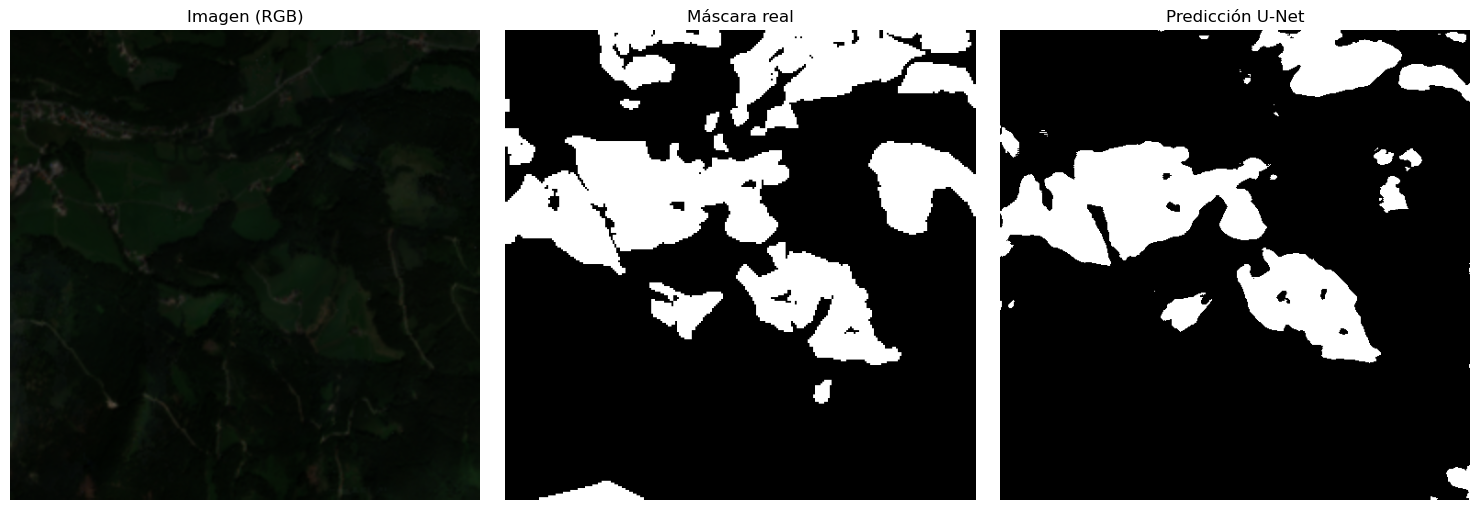

In [68]:
# Evaluación y visualización de resultados en el set de test
model.eval()
with torch.no_grad():
    imgs, masks = next(iter(test_loader))
    imgs = imgs.to(device)
    outputs = model(imgs)
    pred_mask = (outputs > 0.5).float().squeeze().cpu().numpy()
    img = imgs[0].cpu().numpy().transpose(1, 2, 0)
    mask = masks[0].cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img[:, :, :3])
axs[0].set_title('Imagen (RGB)')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Máscara real')
axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title('Predicción U-Net')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()